In [13]:
import os
import zipfile
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
from matplotlib import rcParams
from pathlib import Path  

from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Attention,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Flatten
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    roc_auc_score,
    roc_curve 
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Veri setini yükle (burada değişlik öngörmüyorum)
if tf.test.is_gpu_available():
    print("GPU kullanılabilir!")
else:
    print("GPU kullanılamıyor.") 
train_df = pd.read_pickle('data/train_df_n.pkl')
val_df = pd.read_pickle('data/val_df_n.pkl')
test_df = pd.read_pickle('data/test_df_n.pkl')


GPU kullanılabilir!


2024-03-10 15:00:58.493644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 15:00:58.493788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 15:00:58.493841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
# ImageDataGenerator oluşturma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Rastgele döndürme
    width_shift_range=0.2,  # Rastgele yatay kaydırma
    height_shift_range=0.2,  # Rastgele dikey kaydırma
    shear_range=0.2,  # Rastgele kesme dönüşümü
    zoom_range=0.25,  # Rastgele yakınlaştırma
    horizontal_flip=True,  # Rastgele yatay çevirme
  
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  
    y_col='Gender', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32,
    shuffle=True,
    seed=42 
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, 
    x_col='Filepath', 
    y_col='Gender', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32,
    shuffle=False, 
    seed=42 
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Gender',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',  
    batch_size=32, 
    shuffle=False 
)


Found 18966 validated image filenames.
Found 2371 validated image filenames.
Found 2371 validated image filenames.


In [16]:
def compile_model(model):
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,  
        decay_rate=0.96, 
        staircase=True
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',  # sınıflandırma kaybı
        metrics=['accuracy']  # accuracy metriği
    )

def fit_model(model):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100
    )
    return history

def train_model(model):
    compile_model(model)
    
    # ModelCheckpoint callback'lerini tanımlama
    checkpoint_filepath_loss = 'best_gender_model_loss.h5'
    model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_loss,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)
    
    checkpoint_filepath_mae = 'best_gender_model_mae.h5'
    model_checkpoint_callback_mae = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_mae,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1)
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100,
        callbacks=[
            model_checkpoint_callback_loss,  # val_loss'a göre en iyi modeli kaydetme callback'i
            model_checkpoint_callback_mae   # val_mae'ye göre en iyi modeli kaydetme callback'i
        ]
    )
    
    plot_history(history)
    evaluate_model(model)


def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # accuracy eğitim metriği
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # accuracy doğrulama metriği
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate_model(model):
    results = model.evaluate(test_generator, verbose=0)
    print("Test Loss:", results[0])
    print("Test Accuracy:", results[1])

In [17]:
model = Sequential([
    # Block One
    layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),

    
    layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),

    # Block Two
    layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=5, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),
    
    # Block Three
    layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),
    
    
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.5),
    
    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  # Çıkış katmanı
])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 batch_normalization_6 (Bat  (None, 224, 224, 16)      64        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)     

In [10]:

# base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224, 224, 3))
# inputs = Input(shape=(224, 224, 3))
# x = base_model(inputs)
# x = layers.Dropout(0.5)(x)
# x = Conv2D(128, (1, 1), activation='relu')(x)

# x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dense(128, activation="relu")(x)
# x = Dense(64, activation="relu")(x)

# x = Dense(32, activation="relu")(x)


# outputs = Dense(1, activation='sigmoid')(x)
# model = Model(inputs, outputs)

2024-03-09 17:32:44.266126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 17:32:44.266291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 17:32:44.266368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-03-10 18:06:17.514598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


593/593 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9280
Epoch 1: val_loss improved from inf to 0.20197, saving model to best_gender_model_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.92282, saving model to best_gender_model_mae.h5
593/593 [==============================] - 98s 162ms/step - loss: 0.1734 - accuracy: 0.9280 - val_loss: 0.2020 - val_accuracy: 0.9228
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9251
Epoch 2: val_loss improved from 0.20197 to 0.19574, saving model to best_gender_model_loss.h5

Epoch 2: val_accuracy did not improve from 0.92282
593/593 [==============================] - 96s 162ms/step - loss: 0.1785 - accuracy: 0.9251 - val_loss: 0.1957 - val_accuracy: 0.9224
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9280
Epoch 3: val_loss did not improve from 0.19574

Epoch 3: val_accuracy improved from 0.92282 to 0.92661, saving model to be

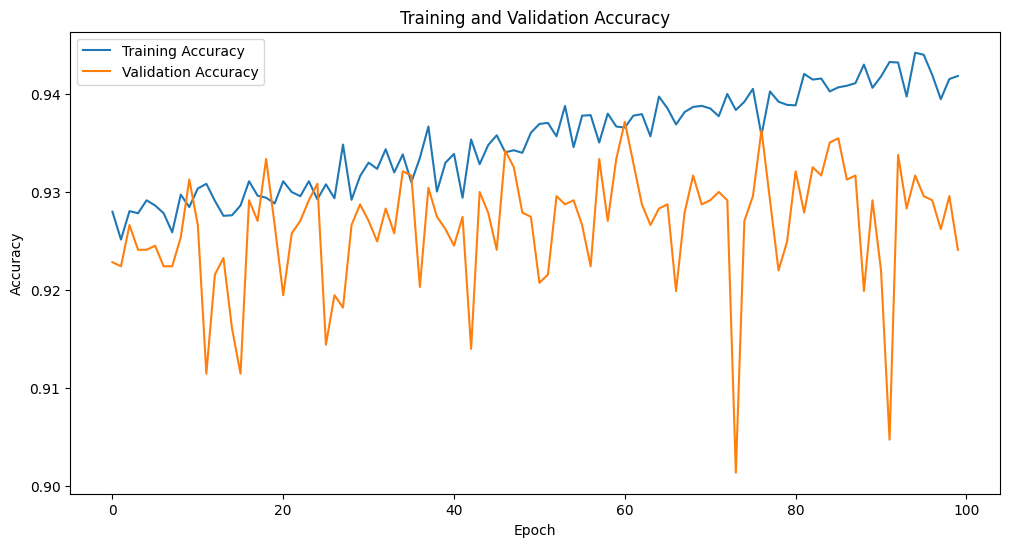

Test Loss: 0.17717920243740082
Test Accuracy: 0.928722083568573


In [28]:
train_model(model)


In [ ]:
from tensorflow.keras.models import load_model
best = load_model('best_gender_model_loss.h5')  # Ağırlıklar mevcut model nesnesine yüklendi
evaluate_model(best)
evaluate_model(model)

In [31]:
best.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 batch_normalization_6 (Bat  (None, 224, 224, 16)      64        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)     

In [ ]:
Test Loss: 0.17072786390781403
Test Accuracy: 0.9367355704307556